In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
data_sample_submission = pd.read_csv("./house-prices-advanced-regression-techniques/sample_submission.csv")
data_train = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
data_test = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [21]:
def metrics_function(predictions, labels):
    predictions[predictions <= 0] = 0.0001
    pred_log, lbl_log = np.log(predictions), np.log(labels)
    se = (pred_log - lbl_log)**2
    mse = np.sum(se)/len(se)
    rmse = np.sqrt(mse)
    return rmse

In [22]:
def get_quadratic_features(x, include_bias=True):
    """Generate quadratic and interaction features.

    # x: np.ndarray [num_samples, num_feature]
    # include_bias: boolean [True, False]

    include_bias=True
    [x_0         [[x_0, 1]        [[x_0, x_0^2, 1]
    x_1..   ->    [x_1, 1]... ->   [x_1, x_1^2, 1]
    x_n]          [x_n, 1]         [x_n, x_n^2, 1]

    [x_0, z_0]         [[x_0, z_0, 1]        [[x_0, z_0, x_0^2, z_0^2, x_0*z_0, 1]
    x_1, z_1   ->      [x_1, z_1, 1]... ->   [x_1, z_1, x_1^2, z_1^2, z_1*z_1, 1]
    x_n, z_n]          [x_n, z_n, 1]         [x_n, z_n, x_n^2, z_n^2, x_n*z_n, 1]

    [x_0, z_0, k_0]        [[x_0, z_0, x_0^2, z_0^2, x_0*z_0, x_0*k_0, z_0*k_0, 1]
    x_1, z_1, k_1   ->     [x_1, z_1, x_1^2, z_1^2, z_1*z_1, 1]
    x_n, z_n, k_n]         [x_n, z_n, x_n^2, z_n^2, x_n*z_n, 1]

    Generate a new feature matrix consisting of all quadratic combinations
    of the features.
    For example, if an input sample is two dimensional and of the form [a, b],
    the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]."""


    if include_bias:
        K = len(x[0])
        arr = np.empty([len(x), int(K * (K + 1) / 2 + 1) + K])
    else:
        K = len(x[0])
        arr = np.empty([len(x), int(K * (K + 1) / 2) + K])

    for row in range(len(x)):
        n_row = []
        if include_bias:
            n_row.append(1)
        i = 0
        for val1 in x[row]:
            i += 1
            n_row.append(val1)
            for val2 in x[row][:i]:
                n_row.append(val1*val2)
        for vl in range(len(n_row)):
            arr[row][vl] = n_row[vl]
    return arr

In [23]:
def calc_cross_val_rmse(fold_num, X, Y):
    if fold_num < 2:
        raise ValueError("fold_num should be more than 2!")
    folds_x = []
    folds_y = []
    for num in range(fold_num+1):
        folds_x.append(X[num*int(len(X)/fold_num):(num+1)*int(len(X)/fold_num)])
    for num in range(fold_num+1):
        folds_y.append(Y[num*int(len(Y)/fold_num):(num+1)*int(len(Y)/fold_num)])
    folds_x[-2] = np.concatenate((folds_x[-2], folds_x[-1]))
    folds_y[-2] = np.concatenate((folds_y[-2], folds_y[-1]))
    folds_x.pop(-1)
    folds_y.pop(-1)
    glob_rmse = 0
    for i in range(fold_num):
        valid_x = folds_x[i]
        valid_y = folds_y[i]
        train_x = np.concatenate(folds_x[:i]+folds_x[i:])
        train_y = np.concatenate(folds_y[:i]+folds_y[i:])
        model = LinearRegression()
        model.fit(train_x, train_y)
        pred = model.predict(valid_x)
        glob_rmse += metrics_function(pred, valid_y)
    return glob_rmse/fold_num
    
        

In [24]:
data_full = pd.concat([data_train, data_test])
num_train = len(data_train)

In [25]:
for column in data_full.columns:
    if data_full.dtypes[column] == object:
        data_full[column] = data_full[column].astype('category').cat.codes

In [26]:
data_full.dropna(axis="columns", inplace=True, thresh=1460*0.3)

In [27]:
ListOfNan = []

In [28]:
for column in data_full.columns:
    if (np.sum(np.isnan(data_full[column])) and column != 'SalePrice'):
        ListOfNan.append(column)

In [29]:
for column in ListOfNan:
    mode = data_full[~data_full[column].isna()][column].mode()[0]
    data_full[column].fillna(mode, inplace=True)
    #print(type(mode), mode, data_full[column].isna().sum())
    

In [30]:
data_full = data_full.drop(columns=["MSZoning","LandSlope","BldgType","ExterCond","Heating","CentralAir","PoolQC"])
y = data_full['SalePrice'].values # train + test
X = data_full.drop(columns=['SalePrice']).values # train + test



# first num_train samples are from train
X_train, X_test = X[:num_train], X[num_train:]

x_train_ind = list(range(num_train))
random.seed(123)
random.shuffle(x_train_ind)
X_train = X_train[x_train_ind]
y_train = y[:num_train][x_train_ind]

num_train_train = int(len(X_train)*0.8)

x_train_train = X_train[:num_train_train]
y_train_train = y_train[:num_train_train]

y_train_test = y_train[int(len(X_train)*0.8):]
x_train_test = X_train[int(len(X_train)*0.8):]


In [31]:
print(calc_cross_val_rmse(10, X_train, y_train))

0.14961839071360275


In [32]:
from sklearn.linear_model import Ridge

In [33]:
print(data_full.shape)

(2919, 74)


In [34]:
print(X_train.shape)

(1460, 73)


In [35]:
print(data_full.head())

   Id  MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandContour  \
0   1          60         65.0     8450       1     -1         3            3   
1   2          20         80.0     9600       1     -1         3            3   
2   3          60         68.0    11250       1     -1         0            3   
3   4          70         60.0     9550       1     -1         0            3   
4   5          60         84.0    14260       1     -1         0            3   

   Utilities  LotConfig  ...  ScreenPorch  PoolArea  Fence  MiscFeature  \
0          0          4  ...            0         0     -1           -1   
1          0          2  ...            0         0     -1           -1   
2          0          4  ...            0         0     -1           -1   
3          0          0  ...            0         0     -1           -1   
4          0          2  ...            0         0     -1           -1   

   MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice

In [36]:
lst = []

In [37]:
print(lst)

[]


In [38]:
print(np.delete(X_test, lst, 1).shape)
            

(1459, 73)


In [42]:
def find_optimal_learning_rate():
    lst_alpha, lst_rmse = [], []
    mmin, malpha = 20, 0
    for x in range(10, 1000, 3):
        model = SGDRegressor(eta0=x/1000)
        model.fit(x_train_train, y_train_train)
        prd = metrics_function(model.predict(x_train_test), y_train_test)
        lst_alpha.append(x)
        lst_rmse.append(prd)
        if prd < mmin:
            malpha = x
            mmin = prd
    plt.plot(lst_alpha, lst_rmse, label='SGD')
    print(mmin)
    plt.legend()
    return malpha

In [43]:
def find_optimal_alpha(model_class):
    lst_alpha, lst_rmse = [], []
    mmin, malpha = 20, 0
    if model_class in [Ridge, Lasso]:
        for x in tqdm(range(1, 2000, 10)):
            model = model_class(alpha=x)
            model.fit(x_train_train, y_train_train)
            prd = metrics_function(model.predict(x_train_test), y_train_test)
            lst_alpha.append(x)
            lst_rmse.append(prd)
            if prd < mmin:
                malpha = x
                mmin = prd
        plt.plot(lst_alpha, lst_rmse, label=str(model_class.__name__))
        plt.xticks([malpha], [malpha], color='red')
        plt.yticks([mmin], [round(mmin, 3)], color='red')
    else:
        model = model_class()
        model.fit(x_train_train, y_train_train)
        prd = metrics_function(model.predict(x_train_test), y_train_test)
        plt.plot([1, 20000], [prd]*2, label=str(model_class.__name__))
    plt.legend()
    return malpha

100%|█████████████████████████████████████████████| 1/1 [00:45<00:00, 45.34s/it]


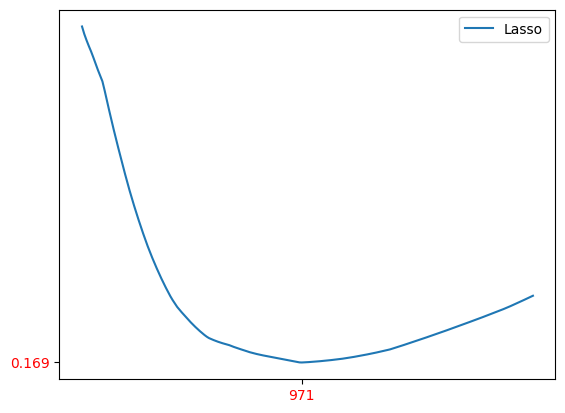

In [44]:
arr = [Lasso]
for tp in tqdm(arr):
    find_optimal_alpha(tp)

In [ ]:
# find_optimal_learning_rate()

In [45]:
model1 = Lasso(alpha=971)
model1.fit(x_train_train, y_train_train)

Lasso(alpha=971)

In [46]:
print("[", end='')
for x in range(len(model1.coef_)):
    if abs(model1.coef_[x]) < 0.1:
        print('"', data_full.columns[x], '",', sep='', end='')
print("]", end='')

["Street","Alley","LandContour","Utilities","Condition2","HouseStyle","RoofMatl","Exterior2nd","Foundation","BsmtCond","BsmtFinType1","BsmtFinType2","Electrical","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","KitchenAbvGr","FireplaceQu","GarageType","GarageCars","GarageQual","GarageCond","PavedDrive","Fence","MiscFeature",]

In [47]:
model2 = LinearRegression()
model2.fit(x_train_train, y_train_train)

LinearRegression()

In [48]:
model3 = LinearRegression()
model3.fit(X_train, y_train)

LinearRegression()

In [49]:
metrics_function(model1.predict(X_train), y_train)

0.15246550629804703

In [50]:
# predictions for test
y_test = model1.predict(X_test)

In [51]:
print("Metrics on train data")
print(metrics_function(model1.predict(x_train_train), y_train_train))
print("-"*20)
print("Metrics on valid data")
print(metrics_function(model1.predict(x_train_test), y_train_test))

Metrics on train data
0.14798150063629795
--------------------
Metrics on valid data
0.1692174782087137


In [52]:
# print("Metrics on train data")
# print(metrics_function(model.predict(x_train_train), y_train_train))
# print("-"*20)



In [53]:
print("Metrics on train data")
print(metrics_function(model2.predict(x_train_train), y_train_train))
print("-"*20)
print("Metrics on valid data")
print(metrics_function(model2.predict(x_train_test), y_train_test))



Metrics on train data
0.1678300451947093
--------------------
Metrics on valid data
0.19484295875589325


In [54]:
print("Metrics on train data")
metrics_function(model3.predict(x_train_train), y_train_train)
print("-"*20)
print("Metrics on valid data")
metrics_function(model3.predict(x_train_test), y_train_test)

Metrics on train data
--------------------
Metrics on valid data


0.17093804221888098

In [55]:
data_test['SalePrice'] = y_test

In [56]:
data_test[['Id', 'SalePrice']].to_csv('/kaggle/working/submission.csv', index=False)

OSError: Cannot save file into a non-existent directory: '/kaggle/working'